
🚀 [TANH] 실험 시작
   에포크 1: Loss = 0.3949, Accuracy = 93.85%
   에포크 2: Loss = 0.2406, Accuracy = 94.75%
   에포크 3: Loss = 0.1993, Accuracy = 95.33%
   에포크 4: Loss = 0.1721, Accuracy = 95.88%
   에포크 5: Loss = 0.1595, Accuracy = 95.61%
   에포크 6: Loss = 0.1421, Accuracy = 96.59%
   에포크 7: Loss = 0.1319, Accuracy = 96.51%
   에포크 8: Loss = 0.1191, Accuracy = 97.01%
   에포크 9: Loss = 0.1094, Accuracy = 96.87%
   에포크 10: Loss = 0.0960, Accuracy = 97.05%
   에포크 11: Loss = 0.0560, Accuracy = 97.69%
   에포크 12: Loss = 0.0511, Accuracy = 97.80%
   에포크 13: Loss = 0.0502, Accuracy = 97.91%
   에포크 14: Loss = 0.0491, Accuracy = 97.62%
   에포크 15: Loss = 0.0469, Accuracy = 97.85%
   에포크 16: Loss = 0.0417, Accuracy = 97.69%
   에포크 17: Loss = 0.0400, Accuracy = 97.72%
   에포크 18: Loss = 0.0436, Accuracy = 97.79%
   에포크 19: Loss = 0.0418, Accuracy = 97.44%
   에포크 20: Loss = 0.0345, Accuracy = 97.93%
   에포크 21: Loss = 0.0188, Accuracy = 98.06%
   에포크 22: Loss = 0.0168, Accuracy = 98.20%
   에포크 23: Loss = 0.0147,

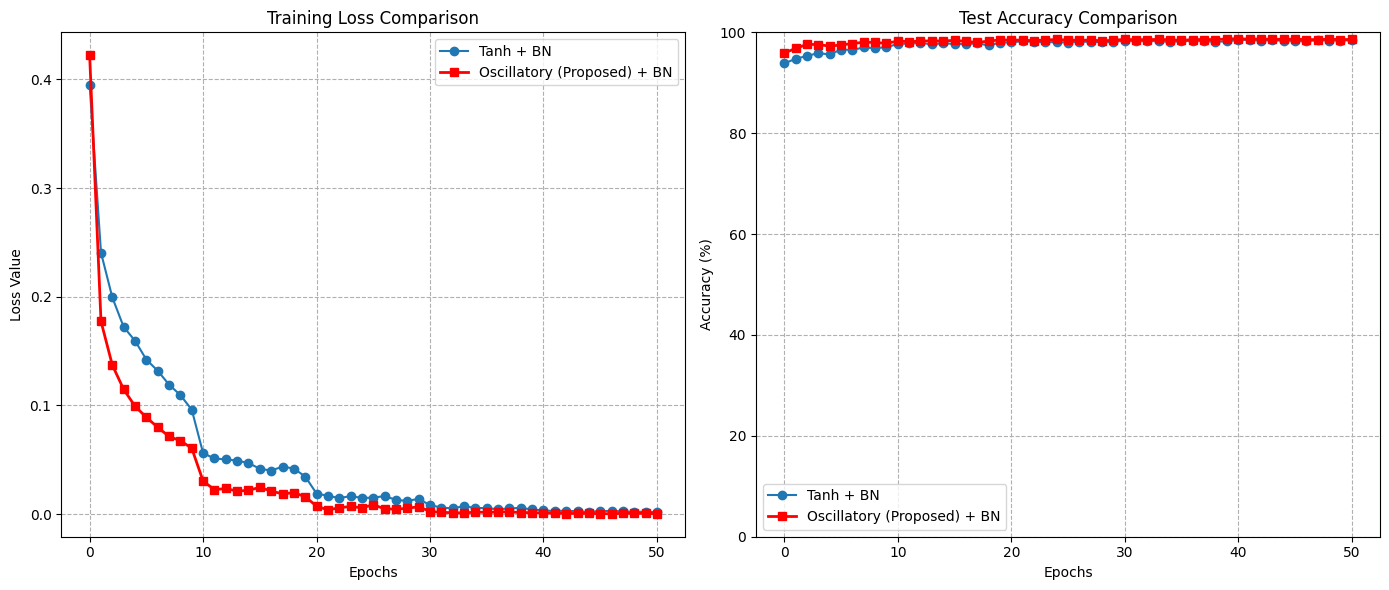

In [1]:
#20층 mlp + 배치정규화 + 조기종료
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 제안된 Oscillatory Soft Gate 정의
# ---------------------------------------------------------
class OscillatorySoftGate(nn.Module):
    """
    f(x) = x * sigmoid(x + a * sin(bx)) 수식을 구현합니다.
    a(진폭)와 b(주파수)는 학습 가능한 파라미터로, 역전파를 통해 최적화됩니다.
    """
    def __init__(self, a=1.0, b=1.0):
        super(OscillatorySoftGate, self).__init__()
        self.a = nn.Parameter(torch.tensor(a))
        self.b = nn.Parameter(torch.tensor(b))

    def forward(self, x):
        # 입력값의 위상(Phase)에 따라 게이트의 임계치가 변조되는 메커니즘입니다.
        gate = torch.sigmoid(x + self.a * torch.sin(self.b * x))
        return x * gate

# ---------------------------------------------------------
# 2. 배치 정규화(BN)가 포함된 20층 DNN 아키텍처
# ---------------------------------------------------------
class DeepNetBN(nn.Module):
    def __init__(self, activation_fn_name, num_layers=20, hidden_dim=256):
        super(DeepNetBN, self).__init__()
        
        layers = []
        # [입력층] 784(28x28) -> 256
        layers.append(nn.Linear(28 * 28, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim)) 
        
        # [은닉층 반복]
        for i in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim)) # 안정적인 학습을 위한 BN 추가
            
            # 활성화 함수 선택 분기
            if activation_fn_name == 'tanh':
                act = nn.Tanh() # 베이스라인: 탄젠트 하이퍼볼릭
            elif activation_fn_name == 'oscillatory':
                act = OscillatorySoftGate() # 제안 모델: Oscillatory Soft Gate
            else:
                act = nn.ReLU()
            layers.append(act)

        self.features = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.features(x)
        x = self.classifier(x)
        return x

# ---------------------------------------------------------
# 3. 하이퍼파라미터 및 데이터 설정
# ---------------------------------------------------------
batch_size = 128
max_epochs = 150        # 최대 에포크 (조기 종료가 적용되므로 넉넉히 설정)
learning_rate = 0.0005  # 정밀한 학습을 위한 낮은 학습률
patience = 10           # 조기 종료를 위한 대기 횟수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), 
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform), 
                         batch_size=batch_size, shuffle=False)

# ---------------------------------------------------------
# 4. 학습 및 조기 종료 함수 (이름: train_with_early_stopping)
# ---------------------------------------------------------
def train_with_early_stopping(name):
    print(f"\n🚀 [{name.upper()}] 실험 시작")
    model = DeepNetBN(name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 10 에포크마다 학습률을 절반으로 줄여 미세한 수렴을 돕습니다.
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    loss_history, acc_history = [], []
    best_acc = 0.0
    trigger_times = 0

    for epoch in range(1, max_epochs + 1):
        # --- 학습 ---
        model.train()
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()
        
        # --- 평가 ---
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                correct += output.argmax(1).eq(target).sum().item()
        
        accuracy = 100. * correct / len(test_loader.dataset)
        avg_loss = total_loss / len(train_loader)
        
        loss_history.append(avg_loss)
        acc_history.append(accuracy)
        print(f"   에포크 {epoch}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

        # --- 조기 종료 로직 ---
        if accuracy > best_acc:
            best_acc = accuracy
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"   [Early Stopping] {patience}회 연속 성능 향상 없음. 종료.")
                break
        
    return loss_history, acc_history

# ---------------------------------------------------------
# 5. 메인 실행 및 시각화 (정확한 함수명 호출)
# ---------------------------------------------------------
if __name__ == "__main__":
    # 주의: 여기서 함수 이름(train_with_early_stopping)을 정확히 호출해야 합니다.
    tanh_loss, tanh_acc = train_with_early_stopping('tanh')
    osc_loss, osc_acc = train_with_early_stopping('oscillatory')

    plt.figure(figsize=(14, 6))

    # [좌] 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(tanh_loss, 'o-', label='Tanh + BN')
    plt.plot(osc_loss, 's-r', label='Oscillatory (Proposed) + BN', linewidth=2)
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend(); plt.grid(True, linestyle='--')

    # [우] 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(tanh_acc, 'o-', label='Tanh + BN')
    plt.plot(osc_acc, 's-r', label='Oscillatory (Proposed) + BN', linewidth=2)
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100); plt.legend(); plt.grid(True, linestyle='--')

    plt.tight_layout()
    plt.show()